# Importing libraries and extracting dataset


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import Dense,Flatten,Dropout, Conv2D, MaxPooling2D,BatchNormalization
import warnings
warnings.filterwarnings('ignore')

**Loading dataset into directory and extracting the zip file**

In [7]:
import os
import zipfile
dataset_path = "animal_data.zip"
dir = "animal_data"  # Directory to extract to

with zipfile.ZipFile(dataset_path, 'r') as zip_ref:
    zip_ref.extractall(dir)

# Update dataset path to the extracted directory
data= os.path.join(dir, 'animal_data')

**Loading the directory into a dataframe**

In [9]:
import pandas as pd
from glob import glob
df = pd.DataFrame({"path":[],"label":[]}) #dataframe for training data
label_list = ['Bear','Bird','Cat','Cow','Deer','Dog','Dolphin','Elephant','Giraffe','Horse','Kangaroo','Lion','Panda','Tiger','Zebra']
#label_list=os.listdir(data)

for i, label in enumerate(label_list):
    img_path = os.path.join(data, label)
    img_list = glob(img_path+'/*.jpg')
    for img in img_list:
        new_data =pd.DataFrame({"path":img,"label":label}, index=[1])
        df = pd.concat([df, new_data], ignore_index=True)   #adding each image with its label to the dataframe

df[["path"]] = df[["path"]].astype(str)
df[["label"]] = df[["label"]].astype(str)


# Overview of the dataset

In [4]:
df.head()

,path,label
0,animal_data\animal_data\Bear\bear_1.jpg,Bear
1,animal_data\animal_data\Bear\Bear_10.jpg,Bear
2,animal_data\animal_data\Bear\Bear_10_1.jpg,Bear
3,animal_data\animal_data\Bear\Bear_10_2.jpg,Bear
4,animal_data\animal_data\Bear\Bear_10_3.jpg,Bear


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1646 entries, 0 to 1645
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   path    1646 non-null   object
 1   label   1646 non-null   object
dtypes: object(2)
memory usage: 25.8+ KB


<Axes: xlabel='count', ylabel='label'>

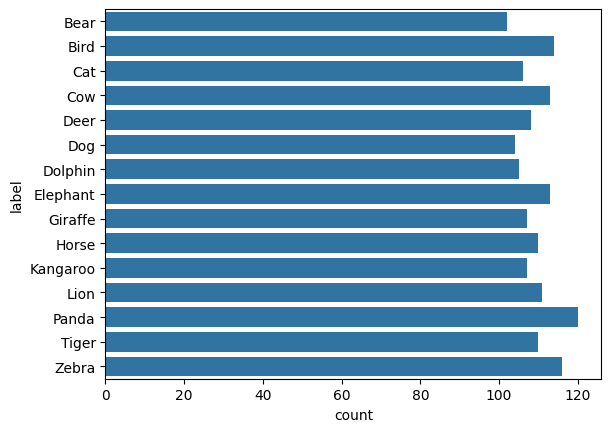

In [6]:
sns.countplot(df['label'])

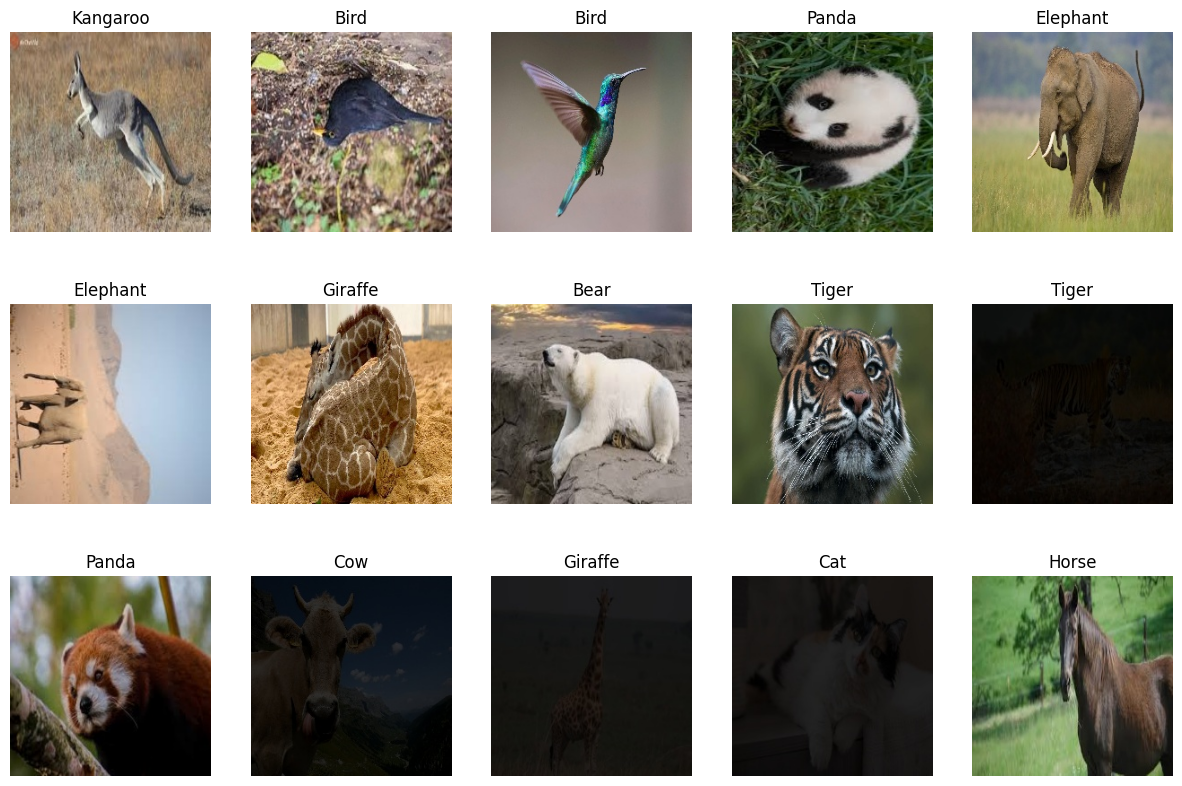

In [11]:
# visualization of some data in the dataset
show_imgs = 15
idx = np.random.randint(0, len(df),size=show_imgs)
fig, axes = plt.subplots(show_imgs//5, 5, figsize=(15,10))
axes = axes.flatten()
for i, ax in enumerate(axes):
    full_path = df.loc[idx[i]]['path']
    ax.imshow(plt.imread(full_path))
    ax.set_title(df.loc[idx[i]]['label'])
    ax.set_axis_off()

# Splitting,Preprocessing and Encoding

In [8]:
X=df['path']
y=df['label']

**Preprocessing images**

In [9]:
from tensorflow.keras.preprocessing.image import load_img, img_to_array
def preprocess(image_paths):
    images = []
    for path in image_paths:
        img = load_img(path, target_size=(96,96))  # Load image with target size
        img_array = img_to_array(img)  # Convert image to NumPy array
        img_array = img_array / 255.0  # Normalize pixel values
        images.append(img_array)
    return np.array(images)
X=preprocess(X)

**Encoding the labels of images**

In [10]:
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
label_encoder = LabelEncoder()
y= label_encoder.fit_transform(y)
y = to_categorical(y, 15)

**Splitting the dataset**

In [11]:
from sklearn.model_selection import train_test_split
X_train,X_temp,y_train,y_temp=train_test_split(X,y,test_size=0.2,random_state=102,shuffle=True)
X_test,X_val,y_test,y_val=train_test_split(X_temp,y_temp,test_size=0.2,random_state=102,shuffle=True)

# Defining Model

In [109]:
model=keras.Sequential([
    Conv2D(filters=16,kernel_size=3,input_shape=(96,96,3),padding="same",activation='relu'),
    MaxPooling2D(pool_size=2),
    #Dropout(0.25),

    Conv2D(filters=32,kernel_size=3,padding="same",activation='relu'),
    MaxPooling2D(pool_size=2),
    Dropout(0.25),

    Flatten(),
    Dense(64,activation='relu'),
    Dropout(0.5),
    Dense(15,activation='softmax')
])

In [111]:
model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])
model.summary()

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_10 (Conv2D)                   │ (None, 96, 96, 16)          │             448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_10 (MaxPooling2D)      │ (None, 48, 48, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_11 (Conv2D)                   │ (None, 48, 48, 32)          │           4,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_11 (MaxPooling2D)      │ (None, 24, 24, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_9 (Dropout)                  │ (None, 24, 24, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_5 (Flatten)                  │ (None, 18432)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_10 (Dense)                     │ (None, 64)                  │       1,179,712 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_10 (Dropout)                 │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_11 (Dense)                     │ (None, 15)                  │             975 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,185,775 (4.52 MB)

 Trainable params: 1,185,775 (4.52 MB)

 Non-trainable params: 0 (0.00 B)

**Training the model**

In [113]:
history=model.fit(X_train, y_train, epochs=50,validation_data=(X_val,y_val))

Epoch 1/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 3s 41ms/step - accuracy: 0.0642 - loss: 2.8125 - val_accuracy: 0.1212 - val_loss: 2.6851
Epoch 2/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - accuracy: 0.1353 - loss: 2.6361 - val_accuracy: 0.1515 - val_loss: 2.6199
Epoch 3/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - accuracy: 0.1384 - loss: 2.6347 - val_accuracy: 0.1818 - val_loss: 2.5584
Epoch 4/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - accuracy: 0.1731 - loss: 2.5541 - val_accuracy: 0.2576 - val_loss: 2.5229
Epoch 5/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - accuracy: 0.1909 - loss: 2.4757 - val_accuracy: 0.1667 - val_loss: 2.4390
Epoch 6/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - accuracy: 0.2287 - loss: 2.4004 - val_accuracy: 0.3030 - val_loss: 2.3025
Epoch 7/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - accuracy: 0.2665 - loss: 2.2770 - val_accuracy: 0.3485 - val_loss: 2.2074
Epoch 8/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - accuracy: 0.2736 - loss: 2.2005 - val_accuracy: 0.3939 - v

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.6037 - loss: 2.0105
Loss =  1.9706090688705444
Accuracy =  61.36363744735718 %


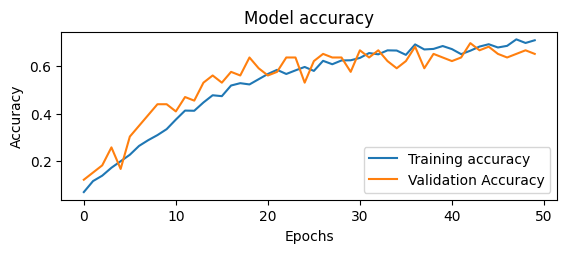

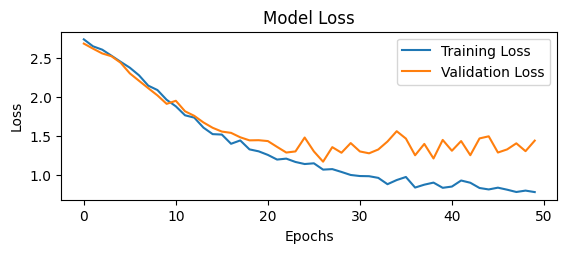

In [115]:
#Loss and accuracy on testing data
results = model.evaluate(X_test,y_test)
print("Loss = ",results[0])
print("Accuracy = ",results[1]*100,"%")

#plotting training and validation accuracy vs epochs
plt.subplot(2,1,1)
plt.plot(history.history['accuracy'], label="Training accuracy")
plt.plot(history.history['val_accuracy'], label="Validation Accuracy")
plt.title("Model accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

#plotting training and validation loss vs epochs
plt.subplot(2,1,2)
plt.plot(history.history['loss'], label="Training Loss")
plt.plot(history.history['val_loss'], label="Validation Loss")
plt.title("Model Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

# Sample Output

label: 
Bird                            Zebra                            Panda                            Dog                            Dog                            

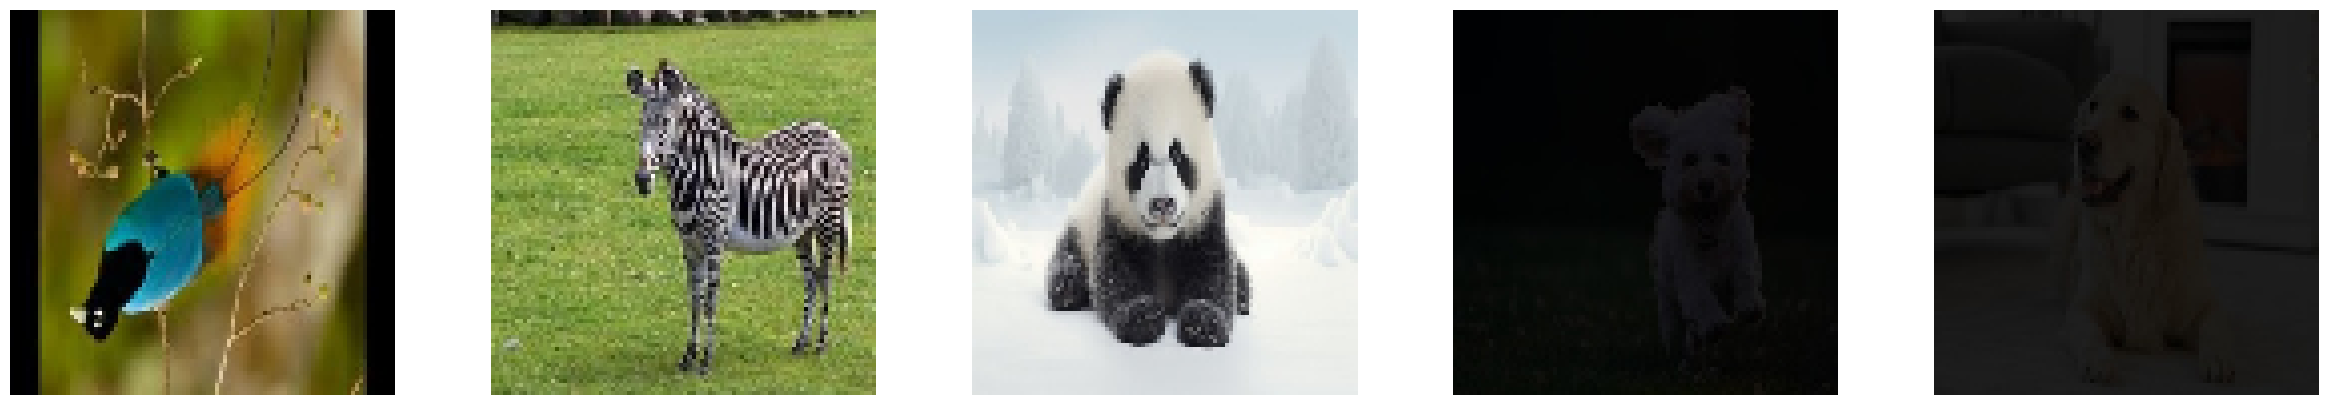

Predicted value: 
Bird                           Zebra                           Panda                           Dog                           Dog                           

In [137]:
n = 5   # = no. of images to see predictions on

index = np.random.choice(X_test.shape[0],n)  # choose random index from test data
print("label: ")
fig, axes = plt.subplots(1, n, figsize=(30, 5))

for i,ind in enumerate(index):
    plt.subplot(1,n,i+1)
    plt.imshow(X_test[ind])
    plt.axis("off")
    print(label_list[np.argmax(y_test[ind])],end="                            ")

plt.show()
print("Predicted value: ")

# printing the predictions

for i,ind in enumerate(index):
    prob = model.predict(X_test[ind].reshape(1,96,96,3),verbose=0)[0]
    label = label_list[np.argmax(prob)]
    print(label,end="                           ")